In [9]:
# Metabook pg. 98
# Using A3 for constants

import numpy as math
import matplotlib.pyplot as plt

W_P = 19.5
W_S = 12.2
W_initial = 6409
P_initial = W_initial / W_P
S_initial = W_initial / W_S

A = 0.74  # Regression constants from Martin's Metabook which cites it from Raymer (2006, Table 3.1)
C = -0.03


c_sl = 0.2 * 32.17 # specific fuel consumtion factor in lb / hp-hr # float(input("Enter the value of c_SL: "))  # Algorithm 3 pg. 50 Metabook
S_wet_initial = 1458
S_wet_initial_rest = S_wet_initial - (2*56*6)
weight_crew = 180
weight_payload = 2000

V = 250 * 1.688
tol = 2e-6  # setting the convergence tolerance
rho = 0.00238
cL_max_takeoff = 1.7 # CHECK #float(input("Enter the cL_max of the wing: ")) #Needs to be approximated based on historical data
cL_max_cruise = 1.6 # CHECK
cL_max_landing = 1.8 # CHECK
V_stall = 52 * 1.688# ft/s approximation - stall speed of a small aircraft # math.sqrt((2 * W_0) / (rho * S_ref * cL_max)) #float(input("Enter the stall velocity (ft/s): "))

s_to = 1500 # RFP #float(input("Enter the takeoff distance (ft): "))
a = 0.0149 
b = 8.134 
discriminant = b**2 - 4*a*(-s_to)
top23 = (-b + math.sqrt(discriminant)) / (2*a)
rho_condition = 0.0023672

s_a = 600 # ft - from Raymer's text pg. 138
s_landing = 1500 # in ft

eta_p = 0.95
c = 1.0447 # Source - Gama
d = 0.5326 # Source - Gama
c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
G3 = 0.083
V_climb = V_stall * 1.1
q_climb = 0.5 * rho * (V_climb)**2
eff_clean = 0.825

V_balked = V_stall * 1.15
q_baled = 0.5 * rho * (V_balked)**2
G1 = 0.03

n = 2 # float(input("Enter the load factor (#g): "))
V_mn = V * 0.5
q_maneuver = 0.5 * rho_condition * V_mn**2

v_cruise = V * 0.5
q_cruise = 0.5 * rho_condition * v_cruise**2

V_ceiling = V * 0.5
Gceiling = (100 / 60) / V_ceiling
q_ceiling = 0.5 * rho * (V_ceiling)**2


def stall_WS():
    WS_stall = (1/2) * (rho) * (V_stall)**2 * cL_max_landing
    return WS_stall

def landing_WS():
    WS_landing = ( (s_landing - s_a) / 80 ) * ((rho_condition / rho) * cL_max_landing)
    return WS_landing

def takeoff(WS): 
    power_weight_ratio_takeoff = WS / ((rho_condition / rho) * cL_max_takeoff * top23)
    return power_weight_ratio_takeoff

def climb(WS, cd_0, AR):
    power_weight_ratio_climb2 = ((V_climb/eta_p) * (G3 + ((q_climb * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_climb))))) / 550
    power_weight_ratio_climb_takeoff2 = power_weight_ratio_climb2 / 0.8
    return power_weight_ratio_climb_takeoff2

def balked_climb(WS, cd_0, AR):
    power_weight_ratio_climb4 = ((V_balked/eta_p) * (G1 + ((q_baled * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_baled))))) / 550
    power_weight_ratio_climb_takeoff4 = power_weight_ratio_climb4 / 0.8
    return power_weight_ratio_climb_takeoff4

def maneuver(WS, cd_0, AR):
    power_weight_ratio_maneuver2 = ((V_mn/eta_p) * ((q_maneuver * cd_0 / WS) + (WS * (n**2) / (AR * math.pi * eff_clean * q_maneuver)))) / 550
    return power_weight_ratio_maneuver2

def cruise(WS, cd_0, AR):
    power_weight_ratio_cruise = ((q_cruise * v_cruise * (cd_0 + ((WS**2)*(0.956**2) / ((q_cruise**2) * math.pi * AR * eff_clean)))) / (550 * eta_p * WS)) / 0.75 # metabook pg. 43
    return power_weight_ratio_cruise

def ceiling(WS, cd_0, AR):
    power_weight_ratio_ceiling2 = ((V_ceiling/eta_p) * (Gceiling + ((q_ceiling * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_ceiling))))) / 550
    return power_weight_ratio_ceiling2

S_range = math.linspace(5, 1000, 201)
P_TO = math.ones(201)
P_CL = math.ones(201)
P_BC = math.ones(201)
P_MN = math.ones(201)
P_CR = math.ones(201)
P_CE = math.ones(201)

takeoff_con = math.ones(201)
climb_con = math.ones(201)
balked_climb_con = math.ones(201)
maneuver_con = math.ones(201)
cruise_con = math.ones(201)
ceiling_con = math.ones(201)

#climb_con[i] = climb(W0_S0, parasite_drag_coeff, AR_iter) * W0
#balked_climb_con[i] = balked_climb(W0_S0, parasite_drag_coeff, AR_iter) * W0
#maneuver_con[i] = maneuver(W0_S0, parasite_drag_coeff, AR_iter) * W0
#cruise_con[i] = cruise(W0_S0, parasite_drag_coeff, AR_iter) * W0
#ceiling_con[i] = ceiling(W0_S0, parasite_drag_coeff, AR_iter) * W0


for i in range(201):
    S0 = S_range[i]
    P_TO[i] = P_initial
    tolerance = 0.1
    converged = False
    while converged == False:
        while i > tol:
            We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_TO[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            i = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        AR_iter = (56**2)/S0
        takeoff_con[i] = takeoff(W0_S0) * W0
        if abs(takeoff_con[i] - P_TO[i]) <= tolerance:
            converged = True
        P_TO[i+1] = takeoff_con[i]

  


KeyboardInterrupt: 

In [10]:
print(P_TO)


[3.28666667e+02 2.93300066e+05 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

1042.6856214693403


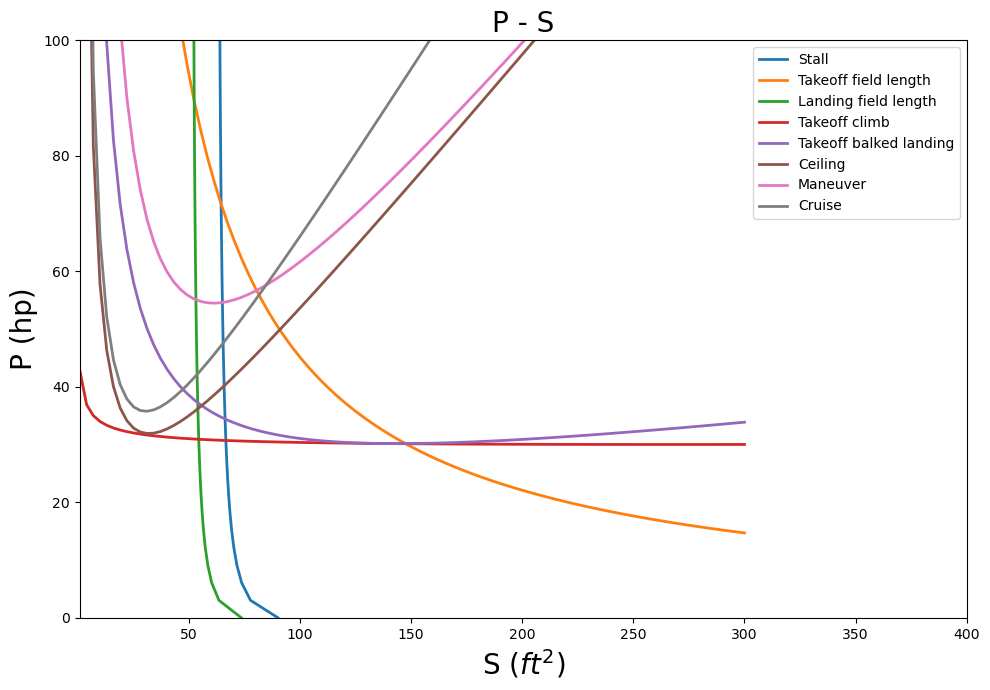

In [41]:
###############################
#### PART 2 #####

S = math.linspace(1, 300, 100)  # Wing area range
#T = math.linspace(1, 1000, 100)  # Thrust range
eta_p = 0.85  # Assumed propeller efficiency

W_engine = 13500 # CHECK float(input("Enter the weight of the engine (lbs): "))
W_engine_dp = 12000 # CHECK float(input("Enter the weight of the engine at the design point (lbs): "))

mu = 3.737 * (10 ** -7)
rho = 0.0023769  # Air density (slug/ft³)
Re = (rho * velocity * 3) / mu  # chord length is taken to be 3

P = math.ones(len(S))
WS_stall = math.ones(len(S))
PW_new_takeoff = math.ones(len(S))
WS_landing = math.ones(len(S))
PW_climb1 = math.ones(len(S))
PW_climb2 = math.ones(len(S))
PW_ceiling1 = math.ones(len(S))
PW_ceiling2 = math.ones(len(S))
PW_balked_climb1 = math.ones(len(S))
PW_balked_climb2 = math.ones(len(S))
PW_maneuver1 = math.ones(len(S))
PW_maneuver2 = math.ones(len(S))
PW_cruise = math.ones(len(S))
S_stall = math.ones(len(S))
P_takeoff = math.ones(len(S))
S_landing = math.ones(len(S))
P_climb1 = math.ones(len(S))
P_climb2 = math.ones(len(S))
P_balked_climb1 = math.ones(len(S))
P_balked_climb2 = math.ones(len(S))
P_ceiling1 = math.ones(len(S))
P_ceiling2 = math.ones(len(S))
P_maneuver1 = math.ones(len(S))
P_maneuver2 = math.ones(len(S))
P_cruise = math.ones(len(S))

# Metabook Algorithm 2 pg. 49
for i in range(len(S)):
    S0 = S[i]
    P[i] = 100 # guessed value
    #list_W0.append(W0)  # adding the current value of W0 to the list
    converged = False
    while (converged == False):
        WP = 19  # design point from W/P vs. W/S diagram from A3
        P0 = W0 / WP
        T_i = P0 * (550 * eta_p / velocity)
        W0_initial = 19000
        W = weight_calc(S0, T_i, W0_initial)
        WS0 = W / S0
        WS_stall[i] = stall_WS()
        S_stall[i] = W / WS_stall[i]
        PW_new_takeoff[i] = takeoff(WS0)
        P_takeoff[i] = W * PW_new_takeoff[i]
        WS_landing[i] = landing_WS()
        S_landing[i] = W / WS_landing[i]
        PW_climb1[i], PW_climb2[i] = climb(WS0)
        P_climb1[i] = W * PW_climb1[i]
        P_climb2[i] = W * PW_climb2[i]
        PW_balked_climb1[i], PW_balked_climb2[i] = balked_climb(WS0)
        P_balked_climb1[i] = W * PW_balked_climb1[i]
        P_balked_climb2[i] = W * PW_balked_climb2[i]
        PW_ceiling1[i], PW_ceiling2[i] = ceiling(WS0)
        P_ceiling1[i] = W * PW_ceiling1[i]
        P_ceiling2[i] = W * PW_ceiling2[i]
        PW_maneuver1[i], PW_maneuver2[i] = maneuver(WS0)
        P_maneuver1[i] = W * PW_maneuver1[i]
        P_maneuver2[i] = W * PW_maneuver2[i]
        PW_cruise[i] = cruise(WS0)
        P_cruise[i] = W * PW_cruise[i]
        if (abs(PW_new_takeoff[i] - P[i]) <= tol):
            converged = True
            break
        P[i] = PW_new_takeoff[i]

print(W)


plt.figure(figsize=(10,7))
plt.title('P - S', fontsize=20)
plt.xlabel("S $(ft^2)$", fontsize=20)
plt.ylabel("P (hp)", fontsize=20)
plt.plot(S_stall, math.linspace(0,300,len(S_stall)), label='Stall', linestyle='-', linewidth=2)
plt.plot(S, (P_takeoff), label='Takeoff field length', linestyle='-', linewidth=2)
plt.plot(S_landing, math.linspace(0,300,len(S_stall)), label='Landing field length', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_climb_takeoff1), label='Takeoff climb min', linestyle='-', linewidth=2)
plt.plot(S, (P_climb1), label='Takeoff climb ', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_climb_takeoff3), label='Takeoff balked landing min', linestyle='-', linewidth=2)
plt.plot(S, (P_climb2), label='Takeoff balked landing', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_ceiling1), label='Ceiling Min', linestyle='-', linewidth=2)
plt.plot(S, (P_ceiling2), label='Ceiling', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_maneuver), label='Maneuver Min', linestyle='-', linewidth=2)
plt.plot(S, (P_maneuver2), label='Maneuver', linestyle='-', linewidth=2)
plt.plot(S, (P_cruise), label='Cruise', linestyle='-', linewidth=2)
#plt.plot(S_Ipanema, power_loading_Ipanema, label='Ipanema', marker="o")
#plt.plot(WS_AT502B, power_loading_AT502B, label='AT502B', marker="o")
#plt.plot(WS_AT602, power_loading_AT602, label='AT602', marker="o")

# Shading the region
#y4 = math.minimum((1/power_weight_ratio_cruise), (1/power_weight_ratio_takeoff))
#plt.fill_between((WS[:42]), 0, y4[:42], color='yellow', alpha=0.3)

plt.ylim(0, 100)
plt.xlim(1,400)
#plt.yticks(math.arange(0, 55, step=5))
#plt.xticks(math.arange(2, 41, step=2))
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


# We = We_W0 * W0

#print(f"Final Takeoff Gross Weight (TOGW): {float(W0):.2f} lbs")
#print(f"Final Empty Weight (We): {float(We):.2f} lbs")
